In [1]:
import pandas as pd
import numpy as np
import texthero as hero
from texthero import preprocessing as ppe
from texthero import visualization as viz
import plotly.express as px
import spacy
from spacy import displacy
import re
import warnings
warnings.filterwarnings("ignore")
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from spellchecker import SpellChecker
from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold, cross_val_score, cross_val_predict
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import pickle

In [2]:
train_df = pd.read_csv('train.csv')
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
test_df = pd.read_csv('test.csv')
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [5]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


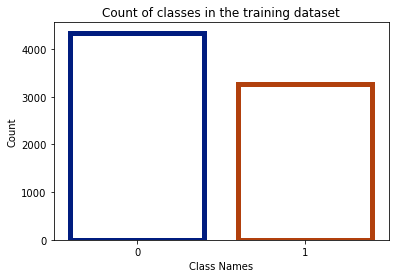

In [6]:
#ax = plt.figure(figsize=(12,6))
sns.countplot(x = 'target', data = train_df, facecolor=(0, 0, 0, 0),
                   linewidth=5,
                   edgecolor=sns.color_palette("dark", 3))
plt.xlabel('Class Names')
plt.ylabel('Count')
plt.title('Count of classes in the training dataset')
plt.show()

In [7]:
train_df.keyword.nunique()

221

In [8]:
#train_df.keyword.value_counts().plot()

In [9]:
train_df.keyword.value_counts()[:10]

fatalities     45
armageddon     42
deluge         42
damage         41
harm           41
body%20bags    41
sinking        41
siren          40
evacuate       40
outbreak       40
Name: keyword, dtype: int64

In [10]:
train_df.location.value_counts()[:10]

USA                104
New York            71
United States       50
London              45
Canada              29
Nigeria             28
UK                  27
Los Angeles, CA     26
India               24
Mumbai              22
Name: location, dtype: int64

In [11]:
test_df.keyword.value_counts()[:10]

deluged               23
demolished            22
rubble                22
snowstorm             21
first%20responders    21
obliteration          21
sirens                21
seismic               21
annihilation          21
avalanche             20
Name: keyword, dtype: int64

In [12]:
test_df.location.value_counts()[:10]

New York          38
USA               37
Worldwide         16
United States     15
Canada            13
London            13
United Kingdom    12
Kenya             12
Nigeria           12
Los Angeles       11
Name: location, dtype: int64

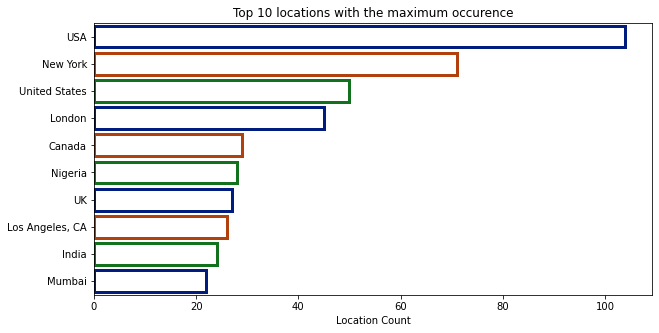

In [13]:
plt.figure(figsize=(10,5))
sns.barplot(y=train_df['location'].value_counts()[:10].index,x=train_df['location'].value_counts()[:10],orient='h',
            facecolor=(0, 0, 0, 0), linewidth = 3,
           edgecolor=sns.color_palette("dark", 3))
plt.xlabel('Location Count')
plt.title('Top 10 locations with the maximum occurence')
plt.show()

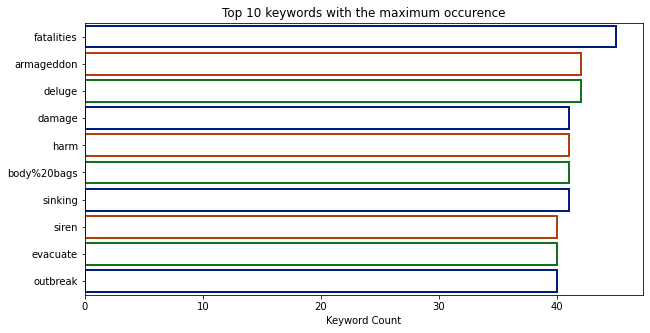

In [14]:
plt.figure(figsize=(10,5))
sns.barplot(y=train_df['keyword'].value_counts()[:10].index,x=train_df['keyword'].value_counts()[:10],orient='h',
            facecolor=(0, 0, 0, 0), linewidth = 2,
           edgecolor=sns.color_palette("dark", 3))
plt.xlabel('Keyword Count')
plt.title('Top 10 keywords with the maximum occurence')
plt.show()

In [15]:
train_df.drop(['keyword', 'location'], axis = 1, inplace = True)
train_df.head()

,id,text,target
0,1,Our Deeds are the Reason of this #earthquake M...,1
1,4,Forest fire near La Ronge Sask. Canada,1
2,5,All residents asked to 'shelter in place' are ...,1
3,6,"13,000 people receive #wildfires evacuation or...",1
4,7,Just got sent this photo from Ruby #Alaska as ...,1


In [16]:
train_df['word count'] = train_df.text.apply(len)
train_df.head()

,id,text,target,word count
0,1,Our Deeds are the Reason of this #earthquake M...,1,69
1,4,Forest fire near La Ronge Sask. Canada,1,38
2,5,All residents asked to 'shelter in place' are ...,1,133
3,6,"13,000 people receive #wildfires evacuation or...",1,65
4,7,Just got sent this photo from Ruby #Alaska as ...,1,88


In [17]:
train_df['word count'].describe()

count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: word count, dtype: float64

In [18]:
#most common words
freq = pd.Series(''.join(train_df['text']).split()).value_counts()[:10]
freq

the    2555
a      1842
to     1803
in     1751
of     1721
and    1295
I       924
for     817
is      814
on      770
dtype: int64

In [19]:
#uncommon words
not_freq = pd.Series(''.join(train_df['text']).split()).value_counts()[-10:]
not_freq

HR                 1
wander             1
??RT               1
cliff.             1
Scissor            1
cupi               1
coming.            1
nades              1
zone@kasiakosek    1
pres               1
dtype: int64

In [20]:
#Data pre-processing

In [21]:
custom_pipeline = [ppe.fillna, ppe.lowercase, ppe.remove_punctuation, ppe.remove_whitespace, 
                  ppe.remove_stopwords, ppe.remove_urls, ppe.remove_digits]

train_df['cleaned_text'] = hero.clean(train_df['text'], custom_pipeline)
test_df['cleaned_text'] = hero.clean(test_df['text'], custom_pipeline)

In [22]:
train_df.head()

,id,text,target,word count,cleaned_text
0,1,Our Deeds are the Reason of this #earthquake M...,1,69,deeds reason earthquake may allah forgive...
1,4,Forest fire near La Ronge Sask. Canada,1,38,forest fire near la ronge sask canada
2,5,All residents asked to 'shelter in place' are ...,1,133,residents asked shelter place notified o...
3,6,"13,000 people receive #wildfires evacuation or...",1,65,people receive wildfires evacuation orders...
4,7,Just got sent this photo from Ruby #Alaska as ...,1,88,got sent photo ruby alaska smoke wildfire...


In [23]:
#lemmatizing

In [24]:
def lemmatizer(r):
    wnl = WordNetLemmatizer()
    words = nltk.word_tokenize(r)
    lemmatized_words = [wnl.lemmatize(word) for word in words if word not in set(stopwords.words('english'))]
    return " ".join(lemmatized_words)

train_df['lemma_cleaned_text'] = train_df['cleaned_text'].apply(lemmatizer)
test_df['lemma_cleaned_text'] = test_df['cleaned_text'].apply(lemmatizer)

In [25]:
train_df.head()

,id,text,target,word count,cleaned_text,lemma_cleaned_text
0,1,Our Deeds are the Reason of this #earthquake M...,1,69,deeds reason earthquake may allah forgive...,deed reason earthquake may allah forgive u
1,4,Forest fire near La Ronge Sask. Canada,1,38,forest fire near la ronge sask canada,forest fire near la ronge sask canada
2,5,All residents asked to 'shelter in place' are ...,1,133,residents asked shelter place notified o...,resident asked shelter place notified officer ...
3,6,"13,000 people receive #wildfires evacuation or...",1,65,people receive wildfires evacuation orders...,people receive wildfire evacuation order calif...
4,7,Just got sent this photo from Ruby #Alaska as ...,1,88,got sent photo ruby alaska smoke wildfire...,got sent photo ruby alaska smoke wildfire pour...


In [26]:
#special character removal

In [27]:
def remove_special_characters(text):
    pattern = r'[^a-zA-Z]'
    text = re.sub(pattern, ' ', text)
    return text

train_df['special_char_cleaned_text'] = train_df['lemma_cleaned_text'].apply(remove_special_characters)
test_df['special_char_cleaned_text'] = test_df['lemma_cleaned_text'].apply(remove_special_characters)

In [28]:
train_df.head()

,id,text,target,word count,cleaned_text,lemma_cleaned_text,special_char_cleaned_text
0,1,Our Deeds are the Reason of this #earthquake M...,1,69,deeds reason earthquake may allah forgive...,deed reason earthquake may allah forgive u,deed reason earthquake may allah forgive u
1,4,Forest fire near La Ronge Sask. Canada,1,38,forest fire near la ronge sask canada,forest fire near la ronge sask canada,forest fire near la ronge sask canada
2,5,All residents asked to 'shelter in place' are ...,1,133,residents asked shelter place notified o...,resident asked shelter place notified officer ...,resident asked shelter place notified officer ...
3,6,"13,000 people receive #wildfires evacuation or...",1,65,people receive wildfires evacuation orders...,people receive wildfire evacuation order calif...,people receive wildfire evacuation order calif...
4,7,Just got sent this photo from Ruby #Alaska as ...,1,88,got sent photo ruby alaska smoke wildfire...,got sent photo ruby alaska smoke wildfire pour...,got sent photo ruby alaska smoke wildfire pour...


In [29]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [30]:
train_df['emoji_cleaned_text'] = train_df['special_char_cleaned_text'].apply(remove_emoji)
test_df['emoji_cleaned_text'] = test_df['special_char_cleaned_text'].apply(remove_emoji)

In [31]:
len(train_df)

7613

In [32]:
tdf = train_df.drop_duplicates(subset = 'special_char_cleaned_text')
len(tdf)

7468

In [33]:
wordcloud = WordCloud().generate(' '.join(train_df['special_char_cleaned_text']))

<Figure size 432x288 with 0 Axes>

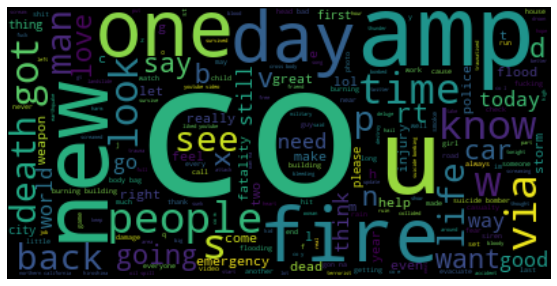

In [34]:
print(wordcloud)
fig = plt.figure(1)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()
#fig.savefig('wordcloud.png', dpi=900)

In [35]:
#name entity recognition (find all the words that are location or person and add it in spell.known())

In [36]:
nlp = spacy.load('en_core_web_sm')
l = []
for i in train_df['special_char_cleaned_text']:
    doc = nlp(i)
    if doc.ents:
        for ent in doc.ents:
                #print(ent.text +' - '+ent.label_+ ' - '+str(spacy.explain(ent.label_)))
            ner = {
                    'Text' : [ent.text],
                    'NER Label' : [ent.label_],
                    'Label explaination' : [str(spacy.explain(ent.label_))]
                }
            l.append(ner)   
            df1 = pd.DataFrame(data = l)
            df1['Text'] = df1['Text'].str.get(0)
            df1['NER Label'] = df1['NER Label'].str.get(0)
            df1['Label explaination'] = df1['Label explaination'].str.get(0)
            
                       
    #else:
     #   print('No named entities found.')
        
#for i in train_df['special_char_cleaned_text']:
 #   doc1 = nlp(i)
  #  show_ents(doc1)

In [37]:
df1

,Text,NER Label,Label explaination
0,california,GPE,"Countries, cities, states"
1,three,CARDINAL,Numerals that do not fall under another type
2,second,ORDINAL,"""first"", ""second"", etc."
3,summer,DATE,Absolute or relative dates or periods
4,last week,DATE,Absolute or relative dates or periods
...,...,...,...
1409,wednesday,DATE,Absolute or relative dates or periods
1410,three,CARDINAL,Numerals that do not fall under another type
1411,two,CARDINAL,Numerals that do not fall under another type
1412,california,GPE,"Countries, cities, states"


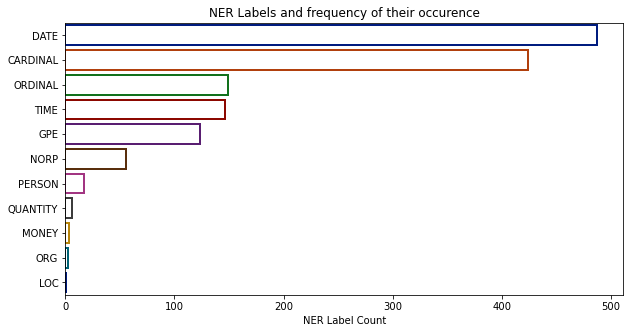

In [38]:
plt.figure(figsize=(10,5))
sns.barplot(y=df1['NER Label'].value_counts().index,x=df1['NER Label'].value_counts(),orient='h',
            facecolor=(0, 0, 0, 0), linewidth = 2,
           edgecolor=sns.color_palette("dark", 11))
plt.xlabel('NER Label Count')
plt.title('NER Labels and frequency of their occurence')
plt.show()

In [39]:
#tfidf vectorization

In [40]:
tfidf_vectorizer = TfidfVectorizer()
train_tfidf = tfidf_vectorizer.fit_transform(train_df['special_char_cleaned_text'])
test_tfidf = tfidf_vectorizer.transform(test_df['special_char_cleaned_text'])

In [41]:
model = XGBClassifier()
# define grid
weights = [1, 10, 25, 50, 75, 99, 100, 1000]
param_grid = dict(scale_pos_weight=weights)
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='roc_auc')
# execute the grid search
grid_result = grid.fit(train_tfidf, train_df.target)
# report the best configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

[13:05:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best: 0.842503 using {'scale_pos_weight': 1}
0.842503 (0.009246) with: {'scale_pos_weight': 1}
0.823187 (0.011511) with: {'scale_pos_weight': 10}
0.813522 (0.012484) with: {'scale_pos_weight': 25}
0.808070 (0.011885) with: {'scale_pos_weight': 50}
0.804345 (0.013946) with: {'scale_pos_weight': 75}
0.802261 (0.011795) with: {'scale_pos_weight': 99}
0.801651 (0.011563) with: {'scale_pos_weight': 100}
0.789004 (0.012300) with: {'scale_pos_weight': 1000}


In [42]:
pred = grid_result.predict(test_tfidf)

In [43]:
with open('tweet_classifier', 'wb') as picklefile:
    pickle.dump(grid_result,picklefile)

In [ ]:
with open('text_classifier', 'rb') as training_model:
    model = pickle.load(training_model)

In [191]:
sample_submission = pd.read_csv('sample_submission.csv')
data={"id":[],"target":[]}
for id,pred_1 in zip(sample_submission['id'].unique(),pred): 
    data["id"].append(id) 
    data["target"].append(pred_1)

    
output=pd.DataFrame(data,columns=["id","target"])
#output
#print(output)
output.to_csv('submission.csv', index=False)